**Abstract**: In this notebook, we use simulation to empirically investigate how opinions spread in a social network under chosen opinion dynamics models. Specifically, we would like to examine how the social network structure as well as the opinion dynamics affect convergence rate of opinions, consensus state, disagreements and polarization of opinions, etc. on generated graphs from stochastic block models.

##### Preparations

In [1]:
import random
import numpy as np
import networkx as nx
import os
import abc
import six
import future.utils
from matplotlib import pyplot as plt
from ndlib.models.ContinuousModel import ContinuousModel
from ndlib.models.ContinuousModelRunner import ContinuousModelRunner
from ndlib.models.compartments.NodeStochastic import NodeStochastic
import ndlib.models.ModelConfig as mc

In [2]:
seed = 1708
random.seed(seed)
np.random.seed(seed)

In [3]:
plt.rcParams['figure.figsize'] = (8, 8)

##### Modified some components from NDlib

In [4]:
# Visualizer for opinion evolution

class OpinionEvolution():
    def __init__(self, model, trends):
        """
        :param model: The model object
        :param trends: The computed simulation trends
        """
        self.model = model
        self.srev = trends
        self.ylabel = "Opinion"

    def plot(self, filename=None):
        """
        Generates the plot

        :param filename: Output filename
        :param percentile: The percentile for the trend variance area
        """

        descr = ""
        all_info = {k: v
                    for k, v in future.utils.iteritems(self.model.params)
                    if k not in ["nodes", "edges", "status"]}
        infos = all_info["model"]

        for k, v in future.utils.iteritems(infos):
            descr += "%s: %s, " % (k, v)
        descr = descr[:-2].replace("_", " ")

        nodes2opinions = {}
        node2col = {}

        last_it = self.srev[-1]["iteration"] + 1
        last_seen = {}

        for it in self.srev:
            sts = it["status"]
            its = it["iteration"]
            for n, vs in sts.items():
                v = vs['opinion']
                if n in nodes2opinions:
                    last_id = last_seen[n]
                    last_value = nodes2opinions[n][last_id]

                    for i in range(last_id, its):
                        nodes2opinions[n][i] = last_value

                    nodes2opinions[n][its] = v
                    last_seen[n] = its
                else:
                    nodes2opinions[n] = [0] * last_it
                    nodes2opinions[n][its] = v
                    last_seen[n] = 0
                    if v < 0.33:
                        node2col[n] = "#ff0000"
                    elif 0.33 <= v <= 0.66:
                        node2col[n] = "#00ff00"
                    else:
                        node2col[n] = "#0000ff"

        mx = 0
        for k, l in future.utils.iteritems(nodes2opinions):
            if mx < last_seen[k]:
                mx = last_seen[k]
            x = list(range(0, last_seen[k]))
            y = l[0 : last_seen[k]]
            plt.plot(x, y, lw=1, alpha=0.5, color=node2col[k])

        plt.title(descr)
        plt.xlabel("Iterations", fontsize=24)
        plt.ylabel(self.ylabel, fontsize=24)
        plt.legend(loc="best", fontsize=18)

        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename)
            plt.clf()
        else:
            plt.show()

## Social Network Models

In this section, we review common random graph models that are used to describe social networks. Specifically, we investigate the stochastic block model.

#### Stochastic Block Model

We use stochastic block model (SBM) to generate graphs, using NetworkX library. The connecting probability matrix is manually chosen such that edge probability within a block is much higher than that between two different blocks.

In [5]:
def generate_ppm(K, N, a, b):
    '''
    Generate a planted partition model.
    Parameters:
    - K: No. of communities
    - N: No. of nodes (assumed that N mod K == 0)
    - a: Connection probability within a community
    - b: Connection probability between two nodes from two different communities
    Return:
    - G_PPM: A NetworkX Graph object
    '''
    sizes = [N // K] * K
    probs = (a-b)*np.identity(K) + np.full((K, K), b)
    G_PPM = nx.stochastic_block_model(sizes, probs, seed=seed)
    return G_PPM

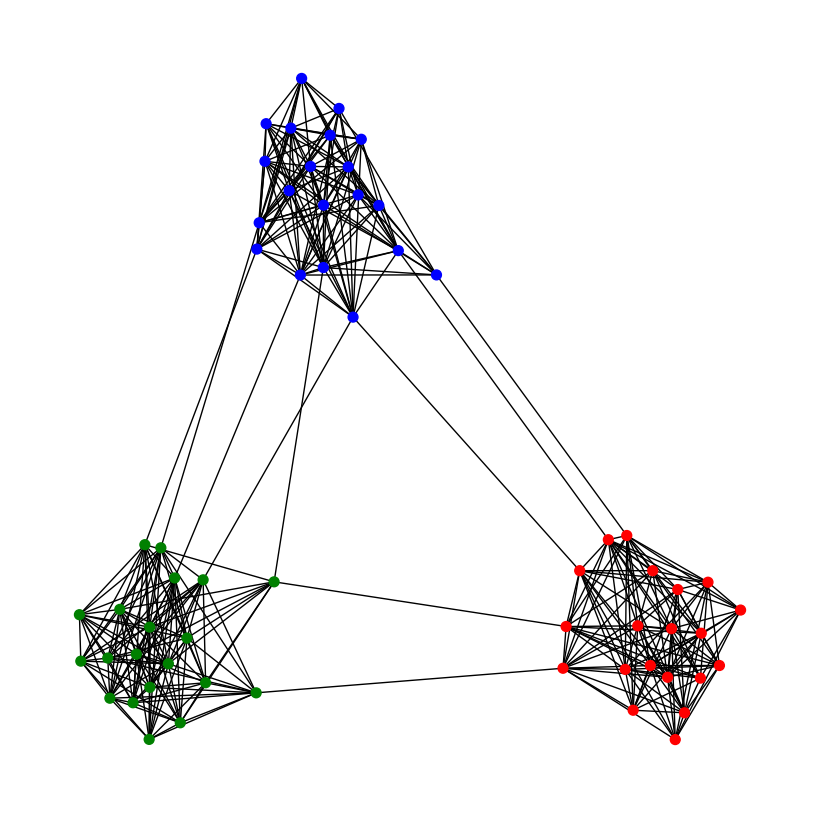

In [6]:
# Example: A SBM(3, 60, 10*np.log(60)/60, np.log(60)/60) graph

K = 3
N = 60
a = 10*np.log(N)/N
b = 0.1*np.log(N)/N

G_PPM = generate_ppm(K, N, a, b)

node_community = nx.get_node_attributes(G_PPM, 'block')
color_map = {0: "red", 1: "green", 2: "blue"}
node_colors = [color_map[node_community[node]] for node in G_PPM.nodes()]
nx.draw(G_PPM, node_color=node_colors, with_labels=False, node_size=50)

## Opinion Dynamics Models

In this section, we consider common linear models for opinion dynamics on a social network. We only use ***unweighted***, ***undirected*** graph.

In [7]:
class Opinion_Dynamics:
    def __init__(self, K, N, a, b, update_opinion, model):
        '''
        Initialize an opinion dynamics model, based on to-be-generated SBM graph and initial opinions.
        Parameters:
        - K: No. of communities
        - N: No. of nodes (assumed that N mod K == 0)
        - a: Connection probability within a community
        - b: Connection probability between two nodes from two different communities
        - update_opinion: Function for opinion updater
        - model: either 'fj' or 'hk'
        '''
        if model != 'hk' and model != 'fj':
            raise ValueError('Wrong specified model')

        # Load the graph, initial opinions, and innate opinions
        self.G = generate_ppm(K, N, a, b)

        # Configuring initial_status
        self.initial_status = {'opinion': set_initial_opinions}
        if model == 'fj':
            self.initial_status['innate opinion'] = set_innate_opinions

        # Configuring model
        self.model = ContinuousModel(self.G)
        self.model.add_status('opinion')
        if model == 'fj':
            self.model.add_status('innate opinion')
        self.config = mc.Configuration()
        self.model.set_initial_status(self.initial_status, self.config)
        self.condition = NodeStochastic(1) # Always true; the updater is called every iteration
        self.model.add_rule('opinion', update_opinion, self.condition)        
        
    def simulate(self, num_sim, num_iter):
        '''
        Simulate the model.
        Parameters:
        - num_sim: No. of simulations
        - num_iter: No. of iterations of each simulation
        Return:
        - results: The results of simulations, by iterations
        '''
        runner = ContinuousModelRunner(self.model, self.config)
        results = runner.run(num_sim, [num_iter], [self.initial_status])
        return results

    def animated_visualize(self, iterations, filename):
        '''
        Visualize a simulation of model.
        Parameters:
        - iterations: Simulation results
        '''
        visualization_config = {'plot_interval': 2,
                                'plot_variable': 'opinion',
                                'show_plot': True,
                                'plot_output': './'+filename+'.gif',
                                'plot_title': filename
                               }
        self.model.configure_visualization(visualization_config)
        self.model.visualize(iterations)

    def mean_visualize(self, iterations):
        '''
        Visualize the mean of opinions and their changes over time.
        Parameters:
        - iterations: Simulation results
        '''
        trends = self.model.build_trends(iterations)
        self.model.plot(trends, len(iterations), delta=True)

    def get_convergence_time(self, iterations, threshold=1e-3):
        '''
        Obtain convergence time, when the mean of changes of all opinions is below delta.
        Parameters:
        - iterations: Simulation results
        - threshold: Threshold for measuring convergence
        Return:
        - convergence_time: No. of iterations for convergence
        '''
        opinion_delta = self.model.get_mean_data(iterations, 'status_delta')['opinion']
        for t in range(1, len(opinion_delta)):
            if abs(opinion_delta[t]) <= threshold:
                return t+1
        return len(opinion_delta)

    def get_final_opinions(self, iterations):
        '''
        Obtain the converged opinions.
        Parameters:
        - iterations: Simulation results
        Return:
        - final_opinions: A vector of converged opinions
        '''
        final_opinions = []
        for i in range(len(self.model.status)):
            final_opinions.append(self.model.status[i]['opinion'])
        return np.array(final_opinions)

    def get_polarization(self, x):
        '''
        Obtain the polarization score from vectors of final opinions.
        Parameters:
        - x: Final opinions
        Return:
        - polarization_score: Polarization score
        '''
        x_bar = np.full((len(x),), np.average(x))
        return np.linalg.norm(x - x_bar)**2

    def get_disagreement(self, x):
        '''
        Obtain the disagreement score from vectors of final opinions.
        Parameters:
        - x: Final opinions
        Return:
        - disagreement_score: Disagreement score
        '''
        L = nx.laplacian_matrix(self.G)
        return (x.T)@L@x

    def plot_opinion_evolution(self, iterations, filename):
        '''
        Plot the evolution of opinions of all agents over iterations.
        Parameters:
        - iterations: Simulation results
        - filename: Directory to save the figure
        '''
        OpinionEvolution(self.model, iterations).plot(filename+".png")

#### Friedkin-Johnsen Model

In [8]:
def FJ_updater(node, graph, status, attributes, constants):
    sum_nominator = status[node]['opinion']
    sum_denominator = 1
    for n in graph.neighbors(node):
        sum_nominator += status[n]['opinion']
        sum_denominator += 1
    new_opinion = (status[node]['innate opinion'] + sum_nominator)/(1 + sum_denominator)
    return new_opinion

#### Hegselmann-Krause Model

In [9]:
def HK_updater(node, graph, status, attributes, constants):
    sum_nominator = status[node]['opinion']
    gamma_cardinality = 1
    for n in graph.neighbors(node):
        if abs(status[n]['opinion'] - status[node]['opinion']) <= eps:
            sum_nominator += status[n]['opinion']
            gamma_cardinality += 1
    new_opinion = sum_nominator/gamma_cardinality
    return new_opinion

## Synthetic Experiments

#### Setting initial opinions, and innate opinions (for FJ model)

In [10]:
def set_initial_opinions(node, graph, status, constants):
    return np.random.normal()

def set_innate_opinions(node, graph, status, constants):
    if node < 20:
        return np.random.normal(loc=-1.0, scale=1.0)
    elif node >= 20 and node < 40:
        return np.random.normal(loc=0.0, scale=1.0)
    else:
        return np.random.normal(loc=1.0, scale=1.0)

#### Set SBM parameters

In [11]:
K = 3
N = 60

#### Set simulation parameters

In [12]:
num_sim = 1
num_iter = 100

#### Friedkin-Johnsen Model

In [13]:
%%capture

# Simulate Friedkin-Johnsen model
a = 10*np.log(N)/N
list_b = [i*np.log(N)/N for i in np.arange(0.1, 10.1, 0.01)]

list_fj = {}

for b in list_b:
    list_fj[b] = {}
    fj_model = Opinion_Dynamics(K, N, a, b, FJ_updater, 'fj')
    list_fj[b]['model'] = fj_model
    fj_results = fj_model.simulate(num_sim, num_iter)[0]
    list_fj[b]['results'] = fj_results
    list_fj[b]['convergence_time'] = fj_model.get_convergence_time(fj_results)
    fj_final_opinions = fj_model.get_final_opinions(fj_results)
    list_fj[b]['polarization'] = fj_model.get_polarization(fj_final_opinions)
    list_fj[b]['disagreement'] = fj_model.get_disagreement(fj_final_opinions)

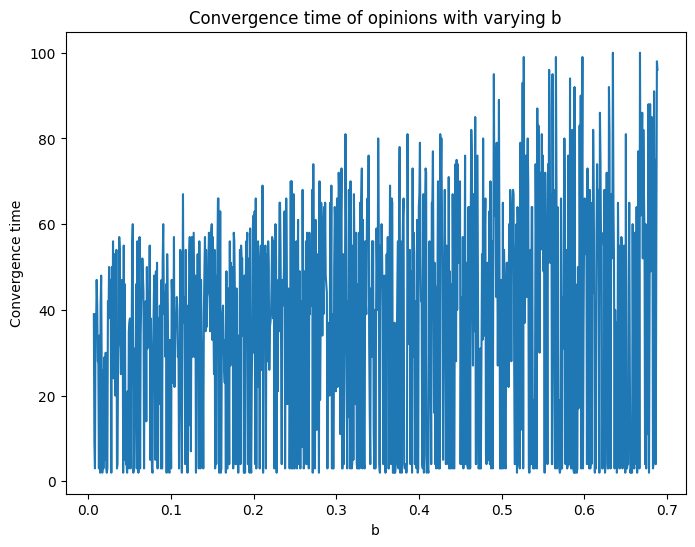

In [14]:
plt.figure(figsize=(8, 6))
plt.title('Convergence time of opinions with varying b')
plt.xlabel('b')
plt.ylabel('Convergence time')
plt.plot(list_b, [list_fj[b]['convergence_time'] for b in list_b])
plt.savefig('convergence_time_fj.png', bbox_inches='tight')
plt.show()

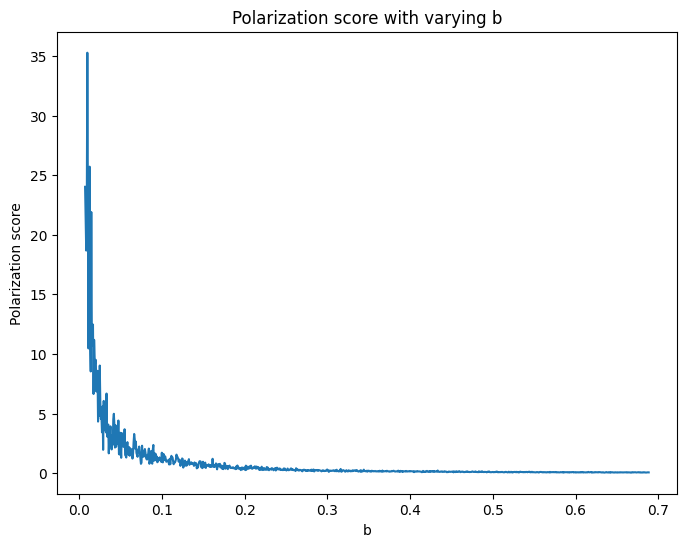

In [15]:
plt.figure(figsize=(8, 6))
plt.title('Polarization score with varying b')
plt.xlabel('b')
plt.ylabel('Polarization score')
plt.plot(list_b, [list_fj[b]['polarization'] for b in list_b])
plt.savefig('polarization_fj.png', bbox_inches='tight')
plt.show()

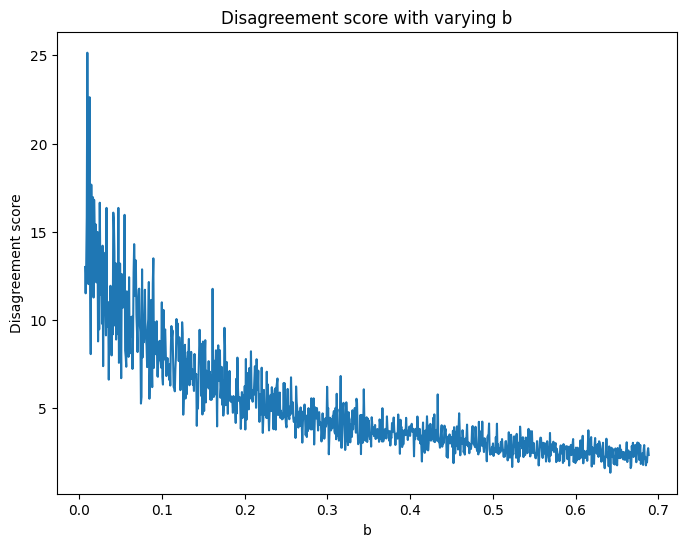

In [16]:
plt.figure(figsize=(8, 6))
plt.title('Disagreement score with varying b')
plt.xlabel('b')
plt.ylabel('Disagreement score')
plt.plot(list_b, [list_fj[b]['disagreement'] for b in list_b])
plt.savefig('disagreement_fj.png', bbox_inches='tight')
plt.show()


Running simulation 1/1

Configuring visualization...
Done configuring the visualization


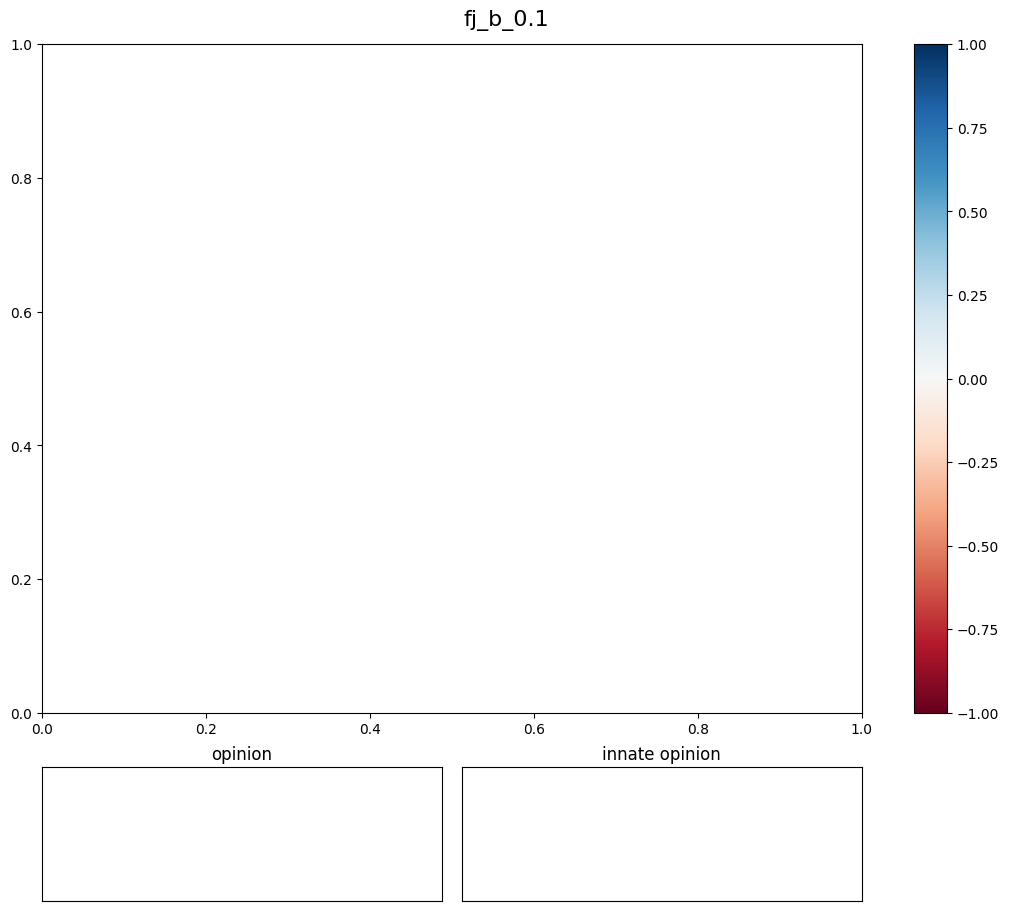

Saving plot at: ./fj_b_0.1.gif ...
Saved: ./fj_b_0.1.gif


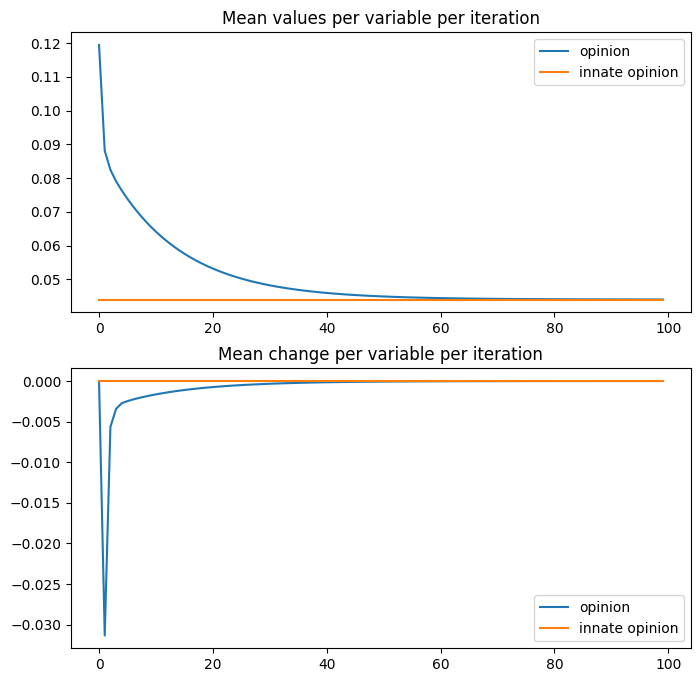

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x800 with 0 Axes>

In [17]:
fj_model_b1 = Opinion_Dynamics(K, N, a, 0.1*np.log(N)/N, FJ_updater, 'fj')
fj_results_b1 = fj_model_b1.simulate(num_sim, num_iter)[0]
fj_model_b1.animated_visualize(fj_results_b1, "fj_b_0.1")
fj_model_b1.mean_visualize(fj_results_b1)
fj_model_b1.plot_opinion_evolution(fj_results_b1, "fj_b_0.1")


Running simulation 1/1

Configuring visualization...
Done configuring the visualization


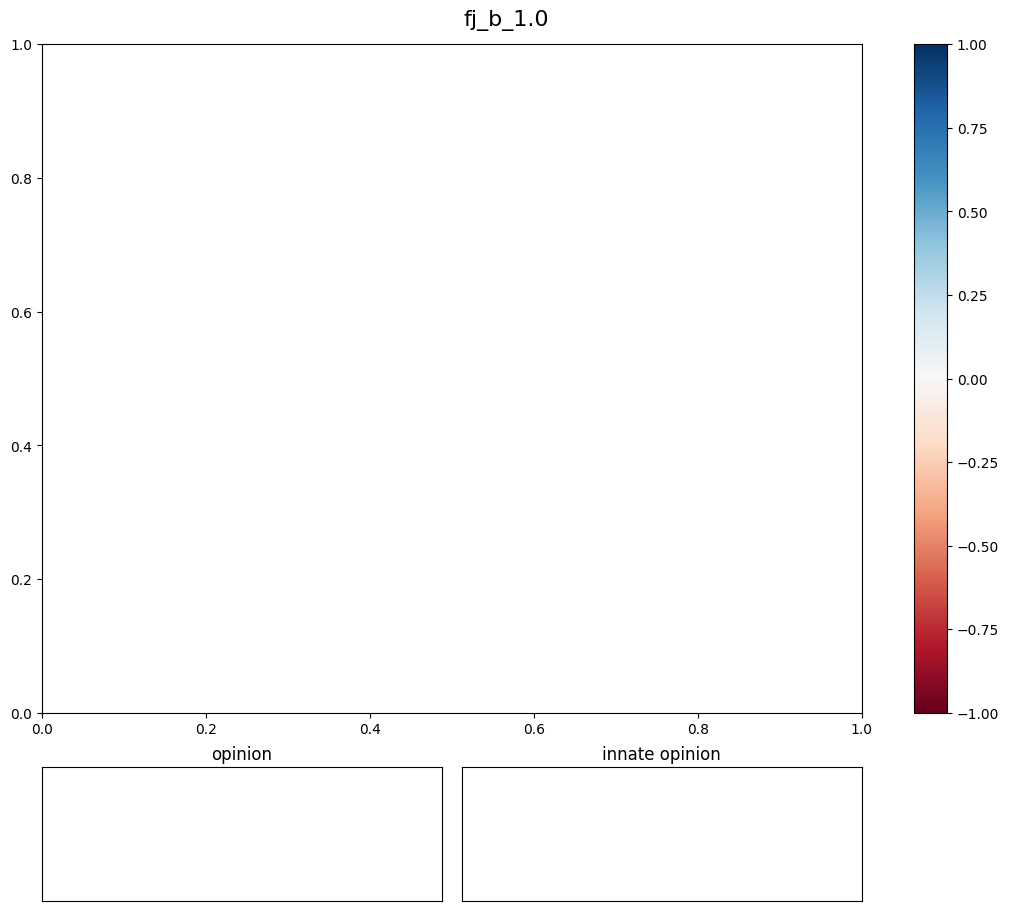

Saving plot at: ./fj_b_1.0.gif ...
Saved: ./fj_b_1.0.gif


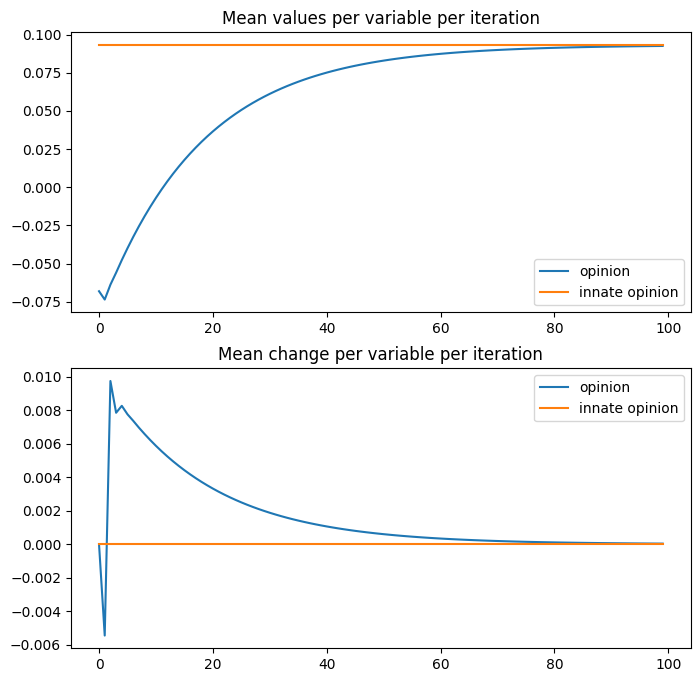

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x800 with 0 Axes>

In [18]:
fj_model_b2 = Opinion_Dynamics(K, N, a, 1.0*np.log(N)/N, FJ_updater, 'fj')
fj_results_b2 = fj_model_b2.simulate(num_sim, num_iter)[0]
fj_model_b2.animated_visualize(fj_results_b2, "fj_b_1.0")
fj_model_b2.mean_visualize(fj_results_b2)
fj_model_b2.plot_opinion_evolution(fj_results_b2, "fj_b_1.0")

#### Hegselmann-Krause Model

In [43]:
%%capture

eps = 1.0

# Simulate Hegselmann-Krause model
a = 10*np.log(N)/N
list_b = [i*np.log(N)/N for i in np.arange(0.0, 10.1, 0.1)]

list_hk = {}

for b in list_b:
    list_hk[b] = {}
    hk_model = Opinion_Dynamics(K, N, a, b, HK_updater, 'hk')
    list_hk[b]['model'] = hk_model
    hk_results = hk_model.simulate(num_sim, num_iter)[0]
    list_hk[b]['results'] = hk_results
    list_hk[b]['convergence_time'] = hk_model.get_convergence_time(hk_results)
    hk_final_opinions = hk_model.get_final_opinions(hk_results)
    list_hk[b]['polarization'] = hk_model.get_polarization(hk_final_opinions)
    list_hk[b]['disagreement'] = hk_model.get_disagreement(hk_final_opinions)

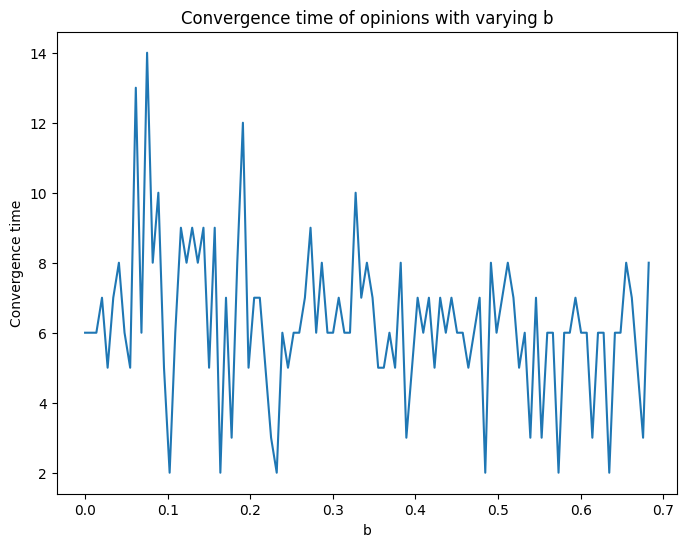

In [44]:
plt.figure(figsize=(8, 6))
plt.title('Convergence time of opinions with varying b')
plt.xlabel('b')
plt.ylabel('Convergence time')
plt.plot(list_b, [list_hk[b]['convergence_time'] for b in list_b])
plt.savefig('convergence_time_hk.png', bbox_inches='tight')
plt.show()

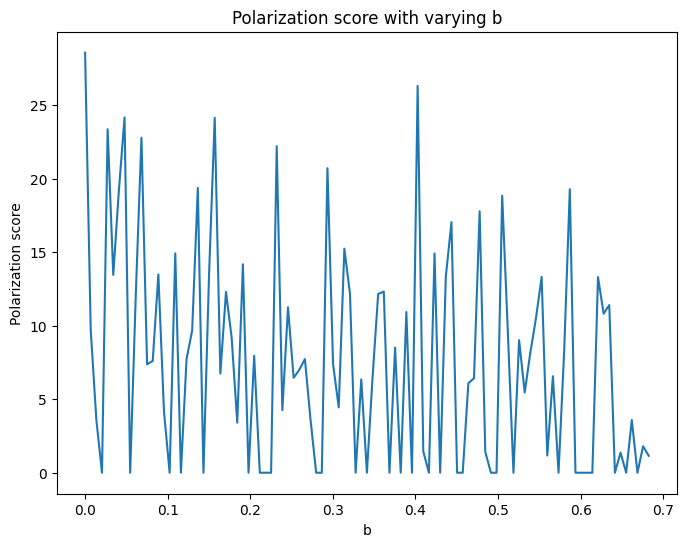

In [45]:
plt.figure(figsize=(8, 6))
plt.title('Polarization score with varying b')
plt.xlabel('b')
plt.ylabel('Polarization score')
plt.plot(list_b, [list_hk[b]['polarization'] for b in list_b])
plt.savefig('polarization_hk.png', bbox_inches='tight')
plt.show()

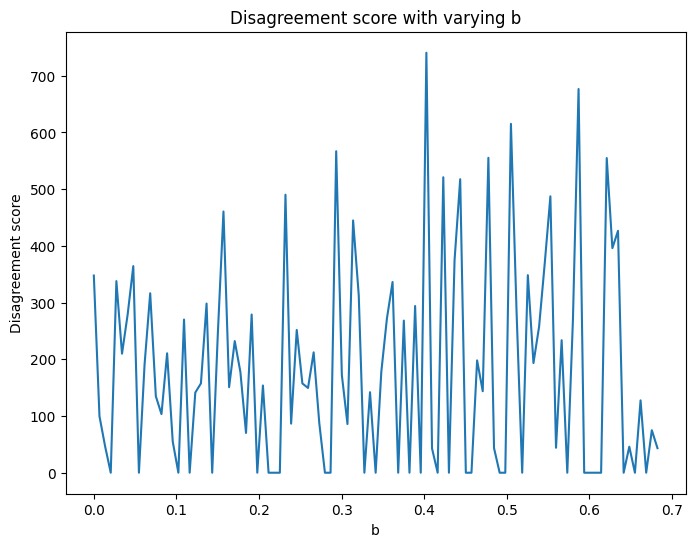

In [46]:
plt.figure(figsize=(8, 6))
plt.title('Disagreement score with varying b')
plt.xlabel('b')
plt.ylabel('Disagreement score')
plt.plot(list_b, [list_hk[b]['disagreement'] for b in list_b])
plt.savefig('disagreement_hk.png', bbox_inches='tight')
plt.show()


Running simulation 1/1

Configuring visualization...
Done configuring the visualization


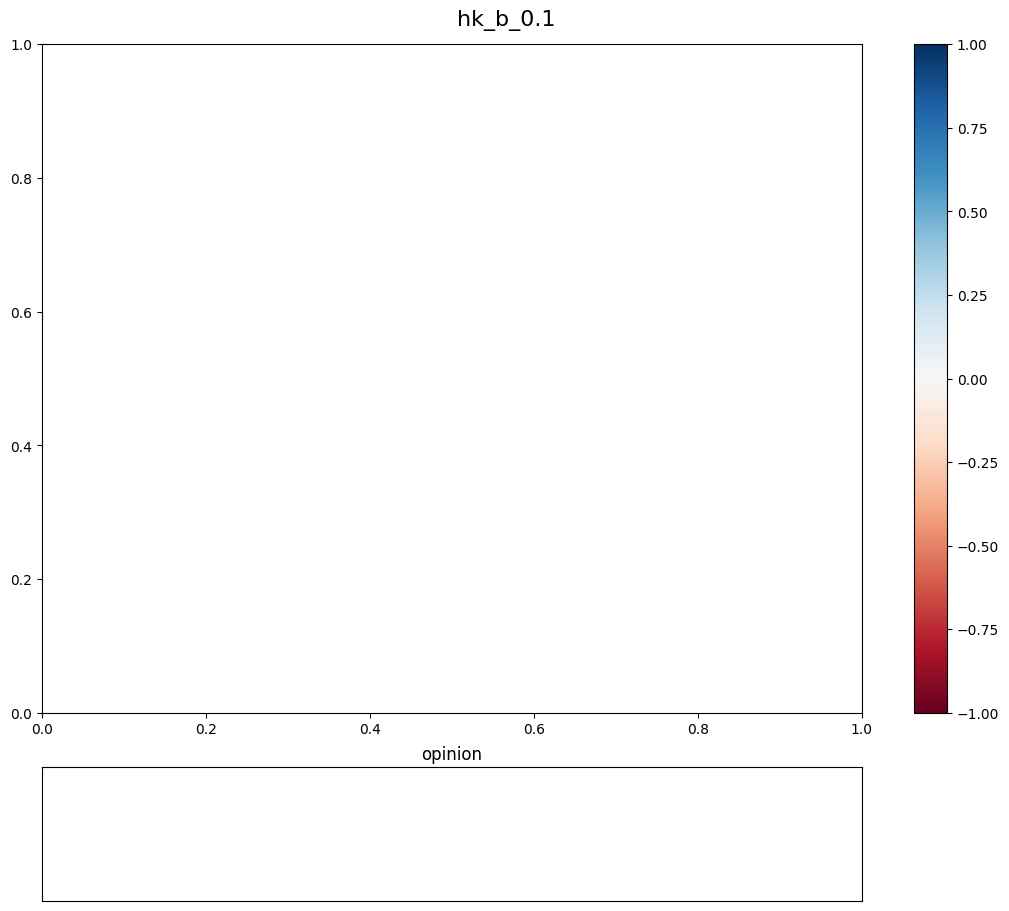

Saving plot at: ./hk_b_0.1.gif ...
Saved: ./hk_b_0.1.gif


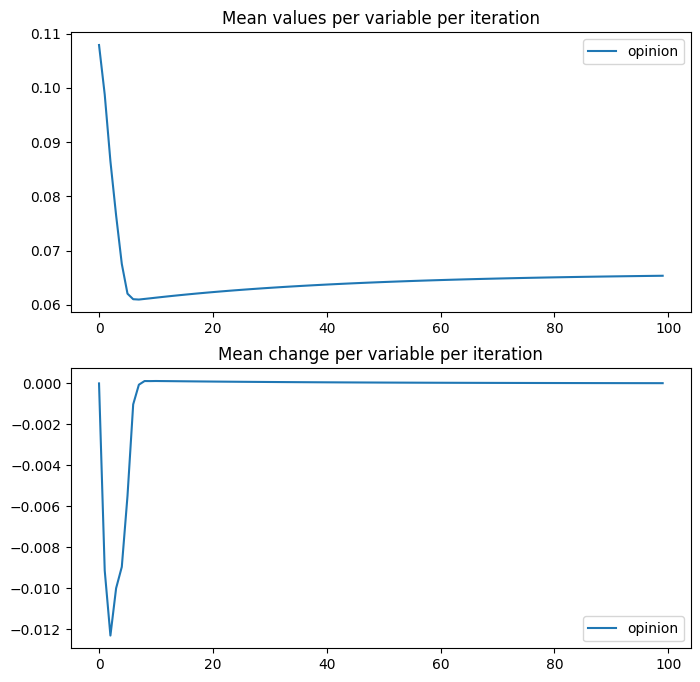

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x800 with 0 Axes>

In [47]:
hk_model_b1 = Opinion_Dynamics(K, N, a, 0.1*np.log(N)/N, HK_updater, 'hk')
hk_results_b1 = hk_model_b1.simulate(num_sim, num_iter)[0]
hk_model_b1.animated_visualize(hk_results_b1, "hk_b_0.1")
hk_model_b1.mean_visualize(hk_results_b1)
hk_model_b1.plot_opinion_evolution(hk_results_b1, "hk_b_0.1")


Running simulation 1/1

Configuring visualization...
Done configuring the visualization


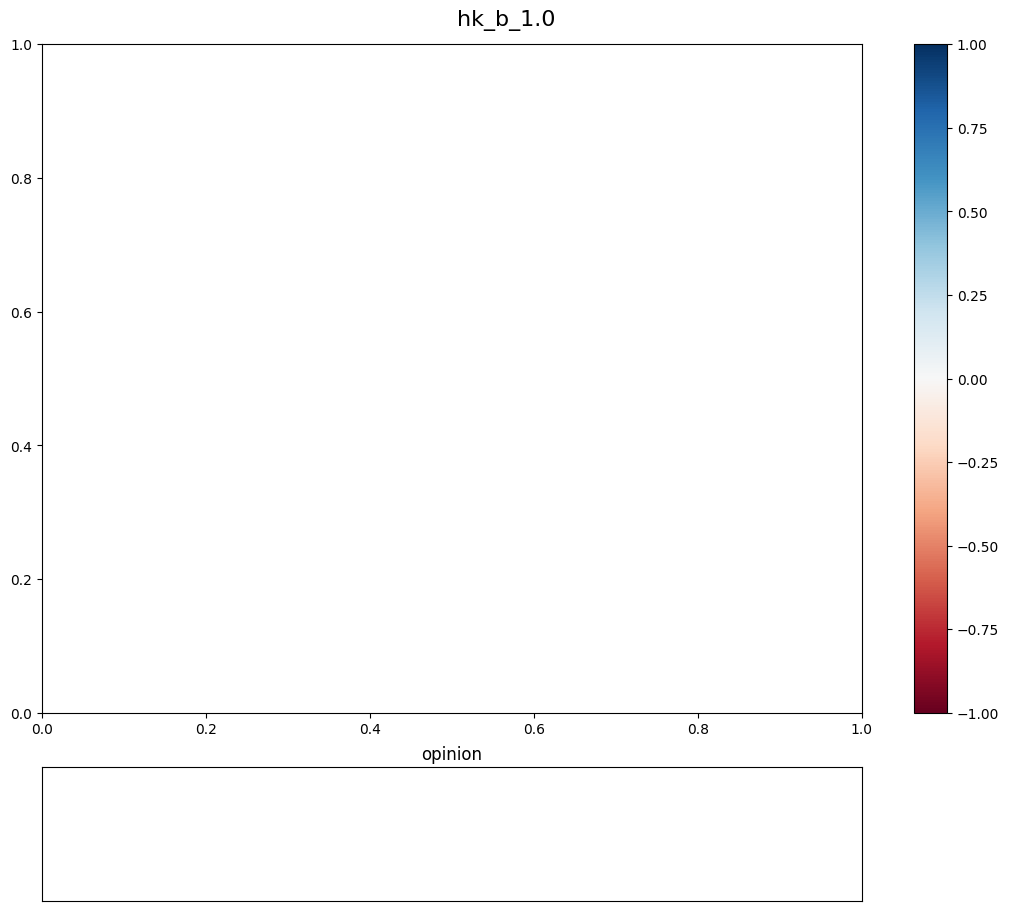

Saving plot at: ./hk_b_1.0.gif ...
Saved: ./hk_b_1.0.gif


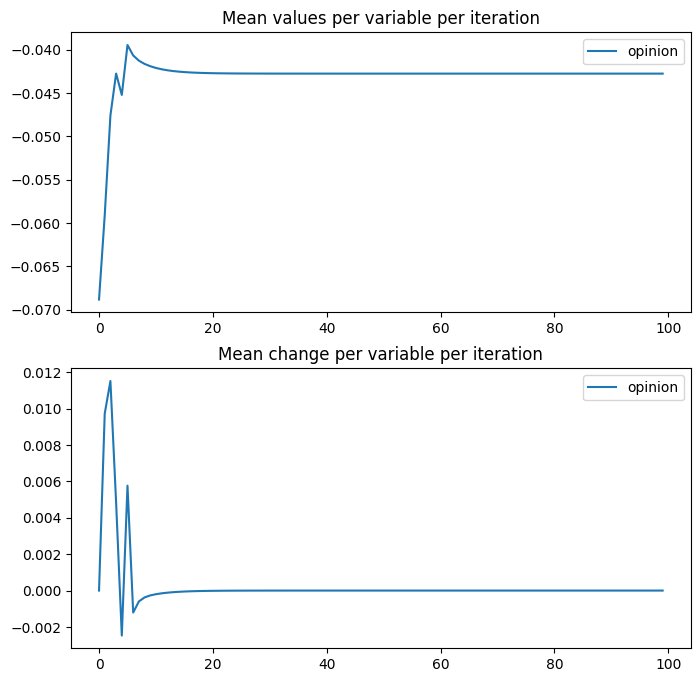

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x800 with 0 Axes>

In [48]:
hk_model_b2 = Opinion_Dynamics(K, N, a, 1.0*np.log(N)/N, HK_updater, 'hk')
hk_results_b2 = hk_model_b2.simulate(num_sim, num_iter)[0]
hk_model_b2.animated_visualize(hk_results_b2, "hk_b_1.0")
hk_model_b2.mean_visualize(hk_results_b2)
hk_model_b2.plot_opinion_evolution(hk_results_b2, "hk_b_1.0")